In [1]:
%%time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jul-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jul-2022/data.csv
CPU times: user 294 µs, sys: 0 ns, total: 294 µs
Wall time: 688 µs


In [2]:
%%time
# Imports Modules 
import math
import os
import sys
import random
import gc
import os
import datetime
import time
import lightgbm as lgb
import optuna


import plotly as py
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
%matplotlib inline

import umap.plot
from umap import UMAP


from statistics import mean
from plotly.offline import init_notebook_mode


# scipy
from scipy.stats import shapiro , stats, probplot,pearsonr,chi2, poisson

# Sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold ,train_test_split, TimeSeriesSplit 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier




CPU times: user 19.9 s, sys: 1.73 s, total: 21.6 s
Wall time: 29.5 s


# Import Data

In [3]:
%%time
data_df = pd.read_csv('/kaggle/input/tabular-playground-series-jul-2022/data.csv')
data_df.head()


CPU times: user 537 ms, sys: 68 ms, total: 605 ms
Wall time: 955 ms


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


In [4]:
data_id = data_df['id']
data_df = data_df.drop('id',axis=1)
data_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389420,-0.912791,0.648951,0.589045,-0.830817,0.733624,2.258560,2,13,14,...,-0.478412,-0.757002,-0.763635,-1.090369,1.142641,-0.884274,1.137896,1.309073,1.463002,0.813527
1,-0.689249,-0.453954,0.654175,0.995248,-1.653020,0.863810,-0.090651,2,3,6,...,-0.428791,-0.089908,-1.784204,-0.839474,0.459685,1.759412,-0.275422,-0.852168,0.562457,-2.680541
2,0.809079,0.324568,-1.170602,-0.624491,0.105448,0.783948,1.988301,5,11,5,...,-0.413534,-1.602377,1.190984,3.267116,-0.088322,-2.168635,-0.974989,1.335763,-1.110655,-3.630723
3,-0.500923,0.229049,0.264109,0.231520,0.415012,-1.221269,0.138850,6,2,13,...,0.619283,1.287801,0.532837,1.036631,-2.041828,1.440490,-1.900191,-0.630771,-0.050641,0.238333
4,-0.671268,-1.039533,-0.270155,-1.830264,-0.290108,-1.852809,0.781898,8,7,5,...,-1.628830,-0.434948,0.322505,0.284326,-2.438365,1.473930,-1.044684,1.602686,-0.405263,-1.987263


# EDA

In [5]:
print("data rows:",data_df.shape[0])
print("data rows:",data_df.shape[1])
print("Null Values: ",data_df.isnull().sum().sum())


data rows: 98000
data rows: 29
Null Values:  0


In [6]:
data_df.describe().T.style.background_gradient(cmap='Reds')

,count,mean,std,min,25%,50%,75%,max
f_00,98000.000000,0.001220,1.002801,-4.732235,-0.675226,0.002022,0.677271,4.490521
f_01,98000.000000,0.005580,1.000742,-4.202795,-0.670985,0.006650,0.677746,4.324974
f_02,98000.000000,-0.001042,1.001373,-4.377021,-0.672779,-0.000324,0.677086,4.560247
f_03,98000.000000,-0.000700,1.000422,-4.010826,-0.672540,-0.003185,0.672097,4.399373
f_04,98000.000000,-0.003522,1.003061,-4.535903,-0.682510,-0.003307,0.677589,4.050549
f_05,98000.000000,-0.001612,1.000532,-4.300767,-0.675066,0.001024,0.673344,4.710316
f_06,98000.000000,-0.003042,0.997434,-4.894525,-0.680421,-0.002053,0.668112,3.998595
f_07,98000.000000,5.545918,3.691840,0.000000,3.000000,5.000000,8.000000,32.000000
f_08,98000.000000,6.763061,4.152348,0.000000,4.000000,6.000000,9.000000,30.000000
f_09,98000.000000,8.193163,5.904919,0.000000,4.000000,7.000000,11.000000,44.000000


# Categorial Columns

In [7]:
%%time
def get_categorial_colmns(dataframe,Verbose=True):
    """
    Determine Categorial Columns of a DataSet
    Input : DataSet
    Output: List
    """
    catg_cols = []
    for col in dataframe.columns:
        if dataframe.dtypes[col] in ['int8','int16','int32','int64','uint8']:
            catg_cols.append(col)
    
    # --------------------------------------------------------------------
    print(f'There are {len(catg_cols)}: Categorial Columns in DataFrame')
    print(catg_cols,end='')
    print('\n')
    return catg_cols

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [8]:
%%time
categorial_columns = get_categorial_colmns(data_df)

There are 7: Categorial Columns in DataFrame
['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13']

CPU times: user 2.14 ms, sys: 0 ns, total: 2.14 ms
Wall time: 2.12 ms


In [9]:
%%time
def get_continuous_columns(dataframe,verbose=True):
    """
    Use this function to retun countinous  columns of a dataframe
    input : dataframe
    output: list 
    
    """
    continuos_column = []
    for column in dataframe.columns:
        if dataframe.dtypes[column] in ['float16' ,'float32' ,'float64']:
            continuos_column.append(column)
    # -----------------------------------------------------------------------
    print(f'There are {len(continuos_column)}: continous  columns  in Datframe')
    print(continuos_column,end=" ")
    print('\n')
    return continuos_column

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [10]:
%%time
continuous_columns = get_continuous_columns(data_df)

There are 22: continous  columns  in Datframe
['f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_14', 'f_15', 'f_16', 'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28'] 

CPU times: user 2 ms, sys: 3 µs, total: 2 ms
Wall time: 1.99 ms


# *Disturbution Of Categorial Columns*

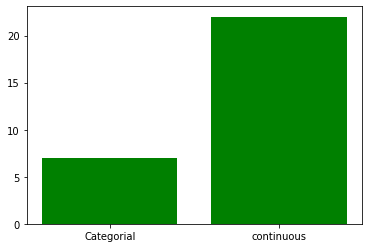

In [11]:
plt.bar([1,2],[len(categorial_columns),len(continuous_columns)],color="green")
plt.xticks([1,2],["Categorial", 'continuous'])
plt.show()

In [12]:
%%time
def dataframe_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Missing_Percent'] = df.isnull().mean().round(2).values
    summary['Uniques'] = df.nunique().values
    return summary


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


In [13]:
%%time
start_time = datetime.datetime.now()

display(dataframe_summary(data_df))

end_time = datetime.datetime.now()
print('\n')
print('--------------------------------------------------------------------------------')
print(f"Job Started at : {start_time}")
print(f"Job Finished at:{end_time}")
print(f'Total Execution Time is:{end_time - start_time}')

Dataset Shape: (98000, 29)


,Name,dtypes,Missing,Missing_Percent,Uniques
0,f_00,float64,0,0.0,98000
1,f_01,float64,0,0.0,98000
2,f_02,float64,0,0.0,98000
3,f_03,float64,0,0.0,98000
4,f_04,float64,0,0.0,98000
5,f_05,float64,0,0.0,98000
6,f_06,float64,0,0.0,98000
7,f_07,int64,0,0.0,32
8,f_08,int64,0,0.0,29
9,f_09,int64,0,0.0,45




--------------------------------------------------------------------------------
Job Started at : 2022-07-18 07:10:04.643984
Job Finished at:2022-07-18 07:10:04.765746
Total Execution Time is:0:00:00.121762
CPU times: user 122 ms, sys: 25 µs, total: 122 ms
Wall time: 122 ms


# *Numerical Columns*

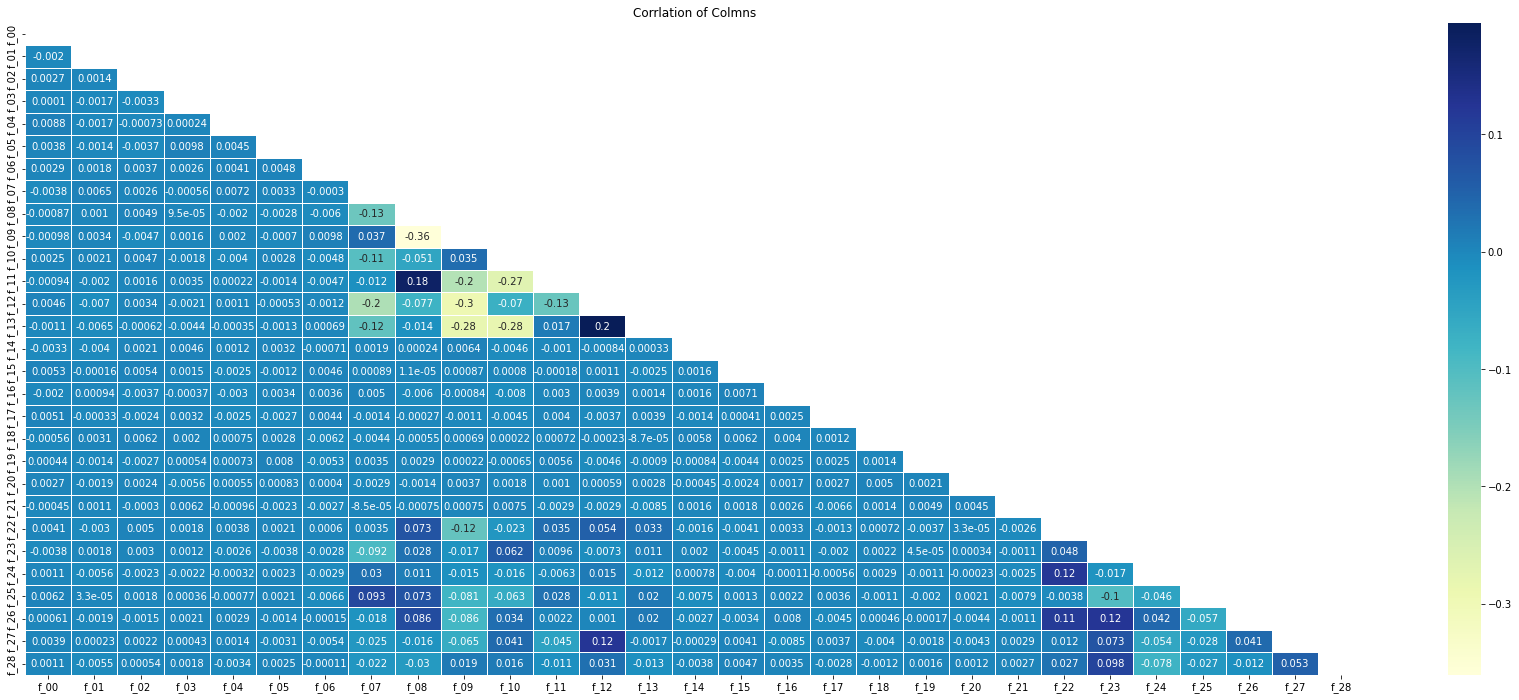

In [14]:
matrix = np.triu(data_df.corr())
plt.figure(figsize=(30,12))
sns.heatmap(data_df.corr(), annot=True,cmap='YlGnBu', mask=matrix,linecolor='white', cbar=True, linewidths=0.5)
plt.title("Corrlation of Colmns")
sns.set_style({'xtick.bottom':True})
plt.show()



--------------------------------------------------------------------------------
Job Started at : 2022-07-18 07:10:07.454041
Job Finished at:2022-07-18 07:10:24.728484
Total Execution Time is:0:00:17.274443
CPU times: user 18.5 s, sys: 2.52 s, total: 21 s
Wall time: 17.3 s


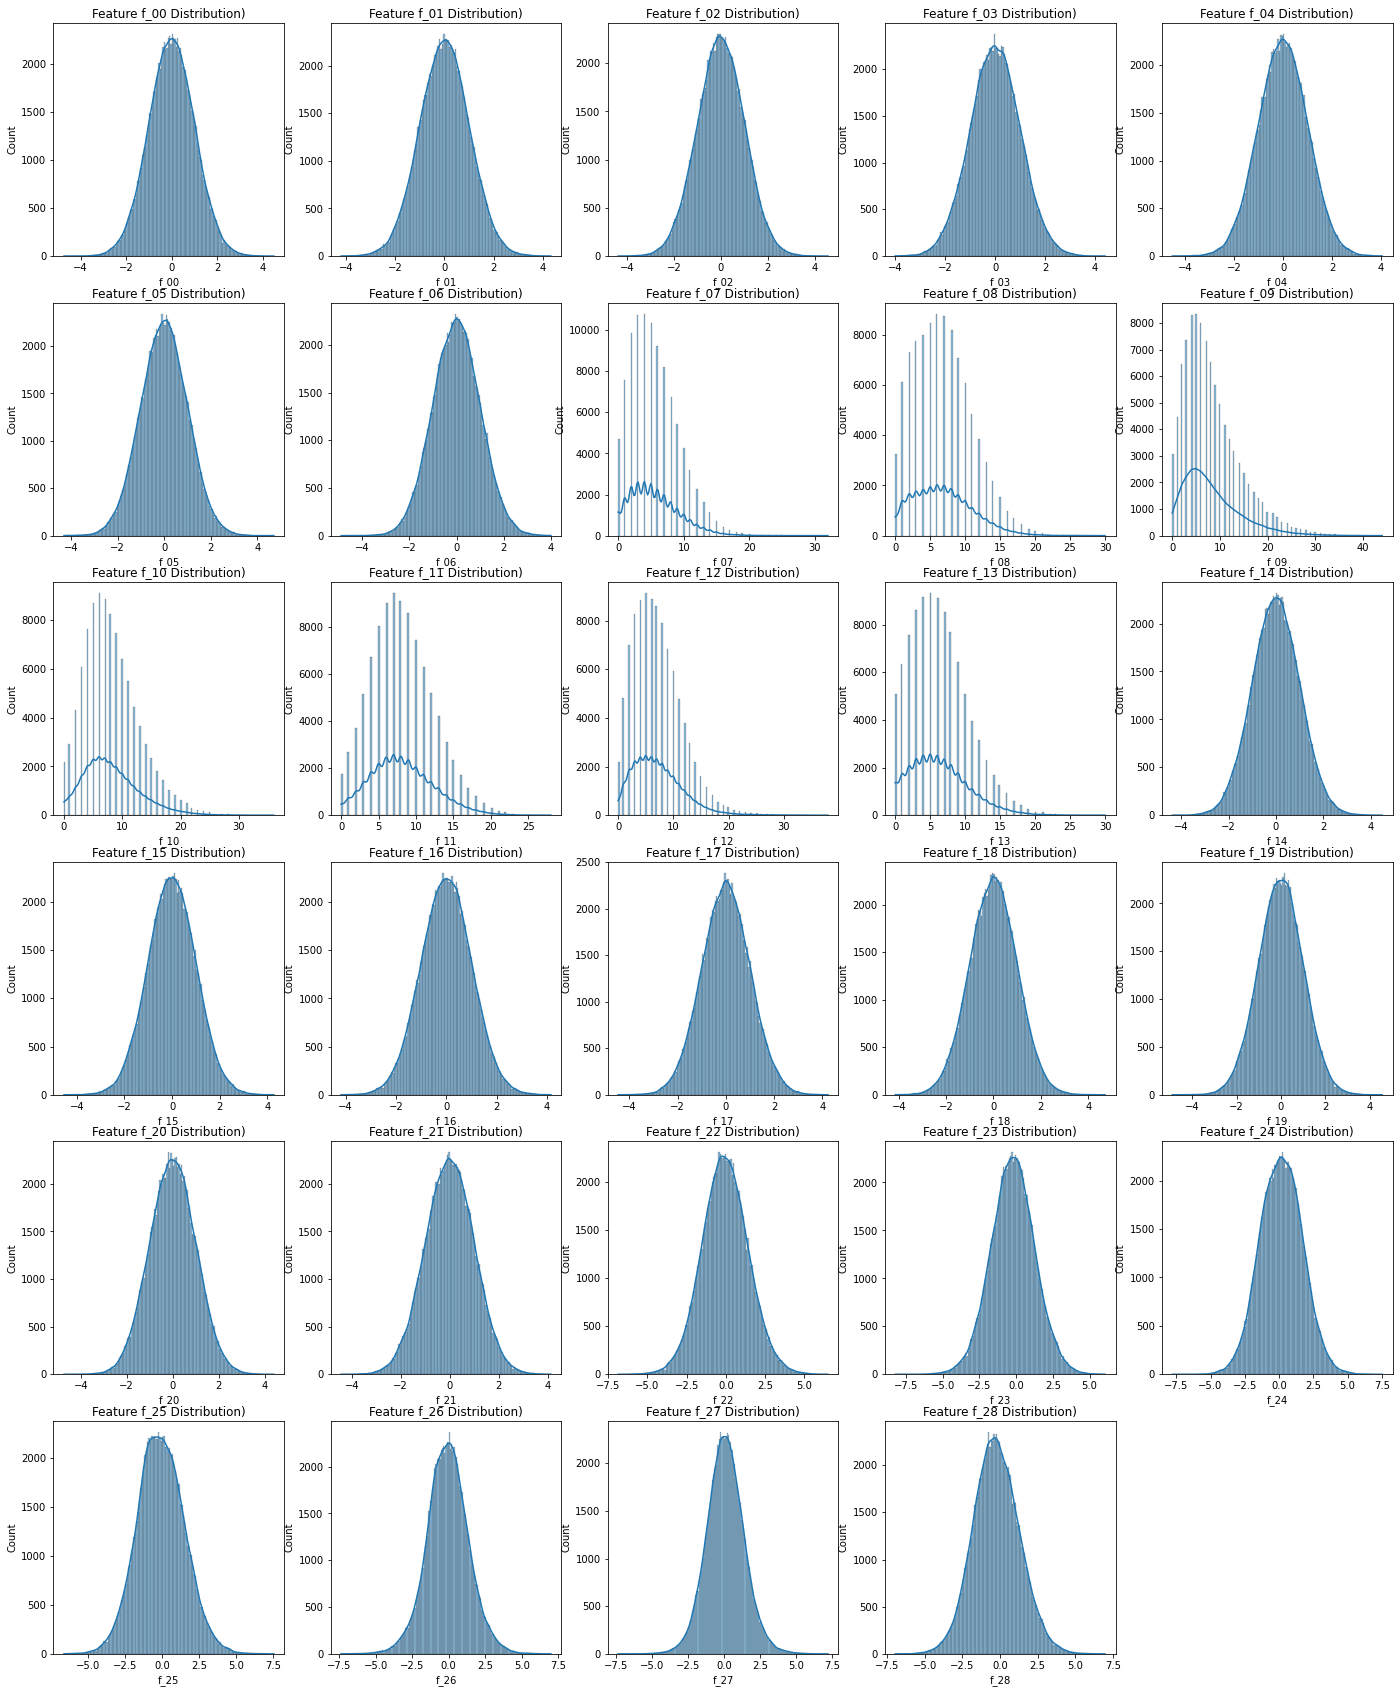

In [15]:
%%time
start_time = datetime.datetime.now()

plt.figure(figsize=(24,30))
columns = list(data_df.columns)

for e,c in enumerate(columns,start=1):
    plt.subplot(6,5,e)
    p = sns.histplot(data_df, x=c,kde=True)
    plt.xlabel(c)
    plt.title(f'Feature {c} Distribution)')



end_time = datetime.datetime.now()
print('\n')
print('--------------------------------------------------------------------------------')
print(f"Job Started at : {start_time}")
print(f"Job Finished at:{end_time}")
print(f'Total Execution Time is:{end_time - start_time}')

# _Distrbution abnormally Detection_

In [16]:
def abnornmally_indicator(df):
    """Detect Abnormally with Shapiro on Data Frame Columns"""
    abnormally = []

    for col in df.columns:
        # Saprio-wilk Test
        col_shapiro = shapiro(df[col])
        abnormally_indicator = col_shapiro.pvalue 

        if abnormally_indicator > 0.05:
            shapiro_resualt = "Normally Distirbuted"
            abnormally.append((col,abnormally_indicator,shapiro_resualt))
        else:
            shapiro_resualt = "Distrbution abbnormally Detectet"
            abnormally.append((col,abnormally_indicator,shapiro_resualt))


    abnormally_df = pd.DataFrame(abnormally,columns=["Feature","abnormally_indicator","Abnormally Status"])  
    return abnormally_df

In [17]:
abnornmally_indicator(data_df)

,Feature,abnormally_indicator,Abnormally Status
0,f_00,8.048047e-01,Normally Distirbuted
1,f_01,9.558341e-01,Normally Distirbuted
2,f_02,7.717363e-01,Normally Distirbuted
3,f_03,5.071116e-01,Normally Distirbuted
4,f_04,4.264995e-01,Normally Distirbuted
5,f_05,9.887279e-01,Normally Distirbuted
6,f_06,3.011470e-01,Normally Distirbuted
7,f_07,0.000000e+00,Distrbution abbnormally Detectet
8,f_08,0.000000e+00,Distrbution abbnormally Detectet
9,f_09,0.000000e+00,Distrbution abbnormally Detectet


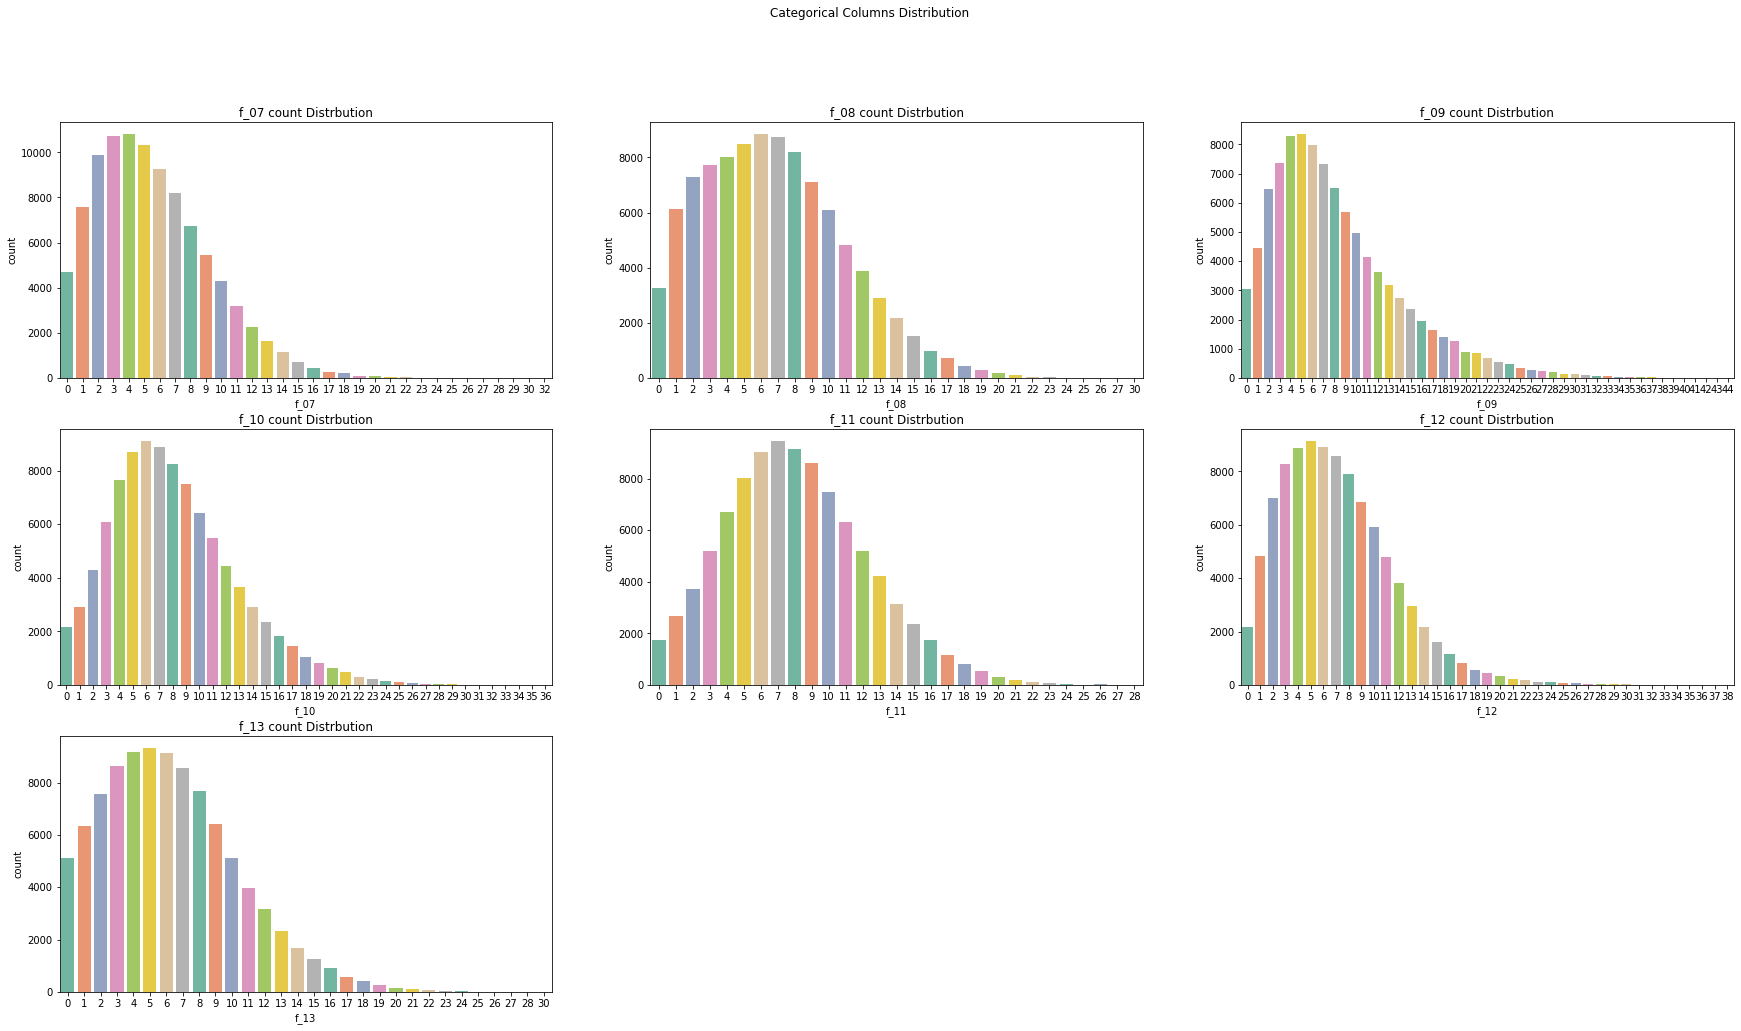

In [18]:
plt.figure(figsize=(30,16))
plt.suptitle("Categorical Columns Distribution")

for each,col in enumerate(categorial_columns, start=1):
    plt.subplot(3,3,each)
    sns.countplot(data=data_df,x=col,palette="Set2")
    plt.title(f'{col} count Distrbution')
    

In [19]:
def poisson_indicator(df):

    poisson = []
    for col in df.columns:
        if df.dtypes[col] in ['int8','int16','int32','int64','uint8']:
            # alpha level
            alpha = 0.05
            # Sample Size
            lenght = len(df[col])
            freedom = lenght -1

            col_mean = df[col].mean()
            dev = ((data_df[col]- col_mean)**2).sum() / col_mean

            q_lower = alpha / 2
            q_upper= (1- alpha) /2

            chi2_lower = chi2.ppf(q_lower, freedom)
            chi2_upper = chi2.ppf(q_upper, freedom)

            if (dev < chi2_lower) or (dev > chi2_upper):
                resualt = " Not Poisson Distributed "
                poisson.append((col,resualt))
            else:
                resualt = "Poisson Distributed"
                poisson.append((col,resualt))
        else:
            resualt = "Not Categorial Column"
            poisson.append((col, resualt))
    poisson_df = pd.DataFrame(poisson ,columns=["Feature","Poisson"])
    return poisson_df

In [20]:
poisson_indicator(data_df)

,Feature,Poisson
0,f_00,Not Categorial Column
1,f_01,Not Categorial Column
2,f_02,Not Categorial Column
3,f_03,Not Categorial Column
4,f_04,Not Categorial Column
5,f_05,Not Categorial Column
6,f_06,Not Categorial Column
7,f_07,Not Poisson Distributed
8,f_08,Not Poisson Distributed
9,f_09,Not Poisson Distributed


# _Preprocess_

In [21]:
# PowerTransformer
pt = PowerTransformer()
x = pt.fit_transform(data_df)
data_df = pd.DataFrame(x, columns=data_df.columns)
data_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,-0.472922,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.423594,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-0.408425,-1.598612,1.194423,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,0.620278,1.283827,0.532884,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-1.614933,-0.432406,0.321899,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058


# Feature Selection

In [22]:
# BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=5,tol=0.01)

# Fit Model
preiction = bgm.fit_predict(x)
pp  = bgm.predict_proba(x)

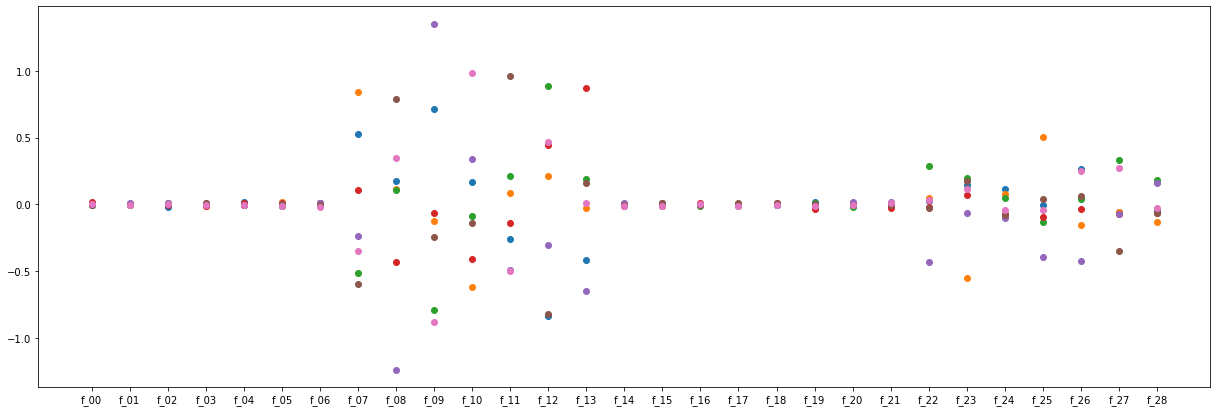

In [23]:
plt.figure(figsize=(21,7))
for i in range(bgm.means_.shape[0]):
    plt.scatter(np.arange(x.shape[1]),bgm.means_[i])
plt.xticks(np.arange(x.shape[1]),labels=data_df.columns)
plt.show()

In [24]:
usefull_features = ['f_07', 'f_08','f_09','f_10','f_11','f_12','f_13','f_22','f_23','f_24','f_25','f_26','f_27','f_28']

# _Create Data Frame with porbility More than 80%_ 

In [25]:
prediction_df = pd.DataFrame(pp,columns=[f'prediction_probea_{i}' for i in range(7)])
prediction_df.head()

,prediction_probea_0,prediction_probea_1,prediction_probea_2,prediction_probea_3,prediction_probea_4,prediction_probea_5,prediction_probea_6
0,0.003510,0.000347,0.002491,0.011334,5.379987e-07,0.977711,0.004606
1,0.000013,0.006764,0.051131,0.903429,1.905648e-02,0.000476,0.019130
2,0.112169,0.000967,0.000010,0.000148,4.141949e-09,0.886635,0.000071
3,0.078531,0.028807,0.011671,0.012068,8.688512e-01,0.000014,0.000057
4,0.000008,0.982739,0.000002,0.017082,7.101590e-07,0.000003,0.000164


In [26]:
data_df[[f'prediction_probea_{i}' for i in range(7)]] =pp
data_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_26,f_27,f_28,prediction_probea_0,prediction_probea_1,prediction_probea_2,prediction_probea_3,prediction_probea_4,prediction_probea_5,prediction_probea_6
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,0.960344,1.042536,0.694234,0.003510,0.000347,0.002491,0.011334,5.379987e-07,0.977711,0.004606
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-0.550783,0.367242,-1.636652,0.000013,0.006764,0.051131,0.903429,1.905648e-02,0.000476,0.019130
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,0.978900,-0.926277,-2.296373,0.112169,0.000967,0.000010,0.000148,4.141949e-09,0.886635,0.000071
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,-0.395085,-0.100021,0.326682,0.078531,0.028807,0.011671,0.012068,8.688512e-01,0.000014,0.000057
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,1.164389,-0.374203,-1.160058,0.000008,0.982739,0.000002,0.017082,7.101590e-07,0.000003,0.000164


In [27]:
data_df["prerdiction_proba"] = np.max(pp,axis=1)
data_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_27,f_28,prediction_probea_0,prediction_probea_1,prediction_probea_2,prediction_probea_3,prediction_probea_4,prediction_probea_5,prediction_probea_6,prerdiction_proba
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,1.042536,0.694234,0.003510,0.000347,0.002491,0.011334,5.379987e-07,0.977711,0.004606,0.977711
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,0.367242,-1.636652,0.000013,0.006764,0.051131,0.903429,1.905648e-02,0.000476,0.019130,0.903429
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-0.926277,-2.296373,0.112169,0.000967,0.000010,0.000148,4.141949e-09,0.886635,0.000071,0.886635
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,-0.100021,0.326682,0.078531,0.028807,0.011671,0.012068,8.688512e-01,0.000014,0.000057,0.868851
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-0.374203,-1.160058,0.000008,0.982739,0.000002,0.017082,7.101590e-07,0.000003,0.000164,0.982739


In [28]:
data_df['predict'] = np.argmax(pp,axis=1)
data_df.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,f_28,prediction_probea_0,prediction_probea_1,prediction_probea_2,prediction_probea_3,prediction_probea_4,prediction_probea_5,prediction_probea_6,prerdiction_proba,predict
0,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,1.039938,...,0.694234,0.003510,0.000347,0.002491,0.011334,5.379987e-07,0.977711,0.004606,0.977711,5
1,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,-0.179925,...,-1.636652,0.000013,0.006764,0.051131,0.903429,1.905648e-02,0.000476,0.019130,0.903429,3
2,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,-0.394246,...,-2.296373,0.112169,0.000967,0.000010,0.000148,4.141949e-09,0.886635,0.000071,0.886635,5
3,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,0.917564,...,0.326682,0.078531,0.028807,0.011671,0.012068,8.688512e-01,0.000014,0.000057,0.868851,4
4,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,-0.394246,...,-1.160058,0.000008,0.982739,0.000002,0.017082,7.101590e-07,0.000003,0.000164,0.982739,1


In [29]:
# Create Train DataSet
train_index = np.array([])
for i in range(7):
    index = data_df[(data_df.predict == i) & (data_df.prerdiction_proba > 0.80)].index
    train_index = np.concatenate((train_index, index))


In [30]:
X = data_df.loc[train_index][usefull_features]
Y = data_df.loc[train_index]['predict']

In [31]:
X.head()

,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
13.0,-0.270117,-0.301642,0.788933,-0.320556,0.731665,-0.614590,-2.025880,1.200330,-0.012989,-0.944818,-0.385018,0.039722,0.303931,-0.513935
18.0,0.530261,-1.213526,0.653205,0.884051,-0.961001,0.148356,-2.025880,-0.354208,0.480815,-1.108745,-1.027170,-0.664048,0.132524,0.080997
25.0,1.541295,0.187543,0.917564,0.706932,-0.961001,-1.292560,0.086073,-1.506413,0.182714,-0.423969,0.084220,0.327505,-0.960513,0.486739
30.0,-0.270117,0.622133,1.039938,-0.320556,0.066905,-0.083596,0.317221,-0.766313,0.857243,-0.946473,0.558696,2.009452,-0.392322,1.111589
45.0,0.756900,1.203800,0.013988,-0.567775,0.066905,-1.737993,-0.162832,-1.058572,0.508469,2.206744,-0.513344,0.132409,-0.177854,-0.236899


In [32]:
Y.head()

13.0    0
18.0    0
25.0    0
30.0    0
45.0    0
Name: predict, dtype: int64

In [33]:
from sklearn.metrics import balanced_accuracy_score ,roc_auc_score

In [34]:
params_lgb = {'learning_rate': 0.07,'objective': 'multiclass','boosting': 'gbdt','verbosity': -1,'n_jobs': -1, 'num_classes':7} 

In [35]:
lgbm_prediction_proba = 0
classifier_score = []

gkf = StratifiedKFold(10,shuffle=True,random_state=1)
for fold,(trn,val) in enumerate(gkf.split(X,Y)):
    X_train = lgb.Dataset(X.iloc[trn],Y.iloc[trn],feature_name=usefull_features)
    X_val = lgb.Dataset(X.iloc[val],Y.iloc[val],feature_name=usefull_features)
    
    lgb_model = lgb.train(params=params_lgb, train_set=X_train,valid_sets=X_val,num_boost_round=5000,callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=True),])
    Y_prediction_proba = lgb_model.predict(X.iloc[val])
    Y_predict = np.argmax(Y_prediction_proba, axis=1)
    
    S = (balanced_accuracy_score(Y.iloc[val],Y_predict),roc_auc_score(Y.iloc[val],Y_prediction_proba,average="weighted",multi_class="ovo"))
    classifier_score.append(S)
    lgbm_prediction_proba =+ lgb_model.predict(data_df[usefull_features]) / 10
pd.DataFrame(classifier_score,columns=["Balanced Accuracy Score","roc accuracy score"]).mean(0)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	valid_0's multi_logloss: 0.0154186
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[792]	valid_0's multi_logloss: 0.0147975
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[596]	valid_0's multi_logloss: 0.0139079
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[407]	valid_0's multi_logloss: 0.0192374
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[536]	valid_0's multi_logloss: 0.0176625
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[590]	valid_0's multi_logloss: 0.0158156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	valid_0's multi_logloss: 0.0117935
Training until validation scores d

Balanced Accuracy Score    0.994533
roc accuracy score         0.999972
dtype: float64

In [36]:
ss = pd.read_csv('../input/tabular-playground-series-jul-2022/sample_submission.csv')

In [37]:
ss.Predicted = np.argmax(lgbm_prediction_proba,axis=1)
ss.to_csv("submission.csv",index=False)